In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df= pd.read_csv('/content/drive/MyDrive/NCDEX/ncdex_stock_data.csv')
df.shape

(4087, 19)

In [3]:
df.head()
df=df[['Commodity','Closing Price']]
df=df.dropna(subset=['Closing Price'])

commodity_list=df['Commodity'].unique().tolist()


In [4]:
df['Commodity'].value_counts()



SOY_OIL                   337
COTTON29MM                292
SOYABEAN                  251
RAPE_MUSTARD_SEEDS        248
SUGARM                    234
CRUDE_PALM_OIL            220
GUARGUM_5MT               205
MAIZEKHARIF               205
CASTORSEEDNEW             205
COTTONSEEDOILCAKEAKOLA    205
GUAR_SEED10               205
WHEATKOTA                 205
CHANA                     205
BARLEY                    204
TURMERIC                  190
JEERA                     161
CORIANDER                 161
PEPPER                    136
KAPASNEW                   89
MAIZERABI                  83
NCDEX FUTURE INDEX         44
Name: Commodity, dtype: int64

In [5]:
df1 =df[df['Commodity']=='SOY_OIL'].reset_index(drop =True)['Closing Price']

In [6]:
len(df1)

337

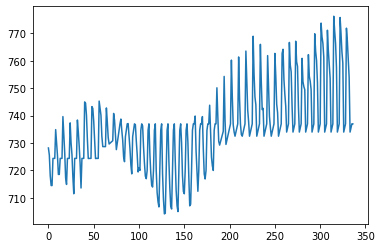

In [7]:
plt.plot(df1)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
##Spitting dataset into train test split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_set,test_set=df1[0:training_size,:],df1[training_size:len(df1),:1]

## Splitting the train_set into X_train , y_train and test_set into X_test,y_test

In [10]:
#Convert array of values into dataset_matrix
def create_dataset(dataset,time_step):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [11]:
time_step=10
X_train,y_train=create_dataset(train_set,time_step)
X_test,y_test=create_dataset(test_set,time_step)


In [12]:
print(X_train.shape)
print(X_test.shape)


(241, 10)
(74, 10)


In [13]:
#reshape input as [samples,time_step,feature] convert it to 3 dimentional array as required by LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [14]:
#Creating a stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')





In [15]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=0)

In [16]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [17]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(y_test,test_predict))

0.15114003499505982

In [18]:
len(test_set)-time_step

75

In [19]:
x_input=test_set[(len(test_set)-time_step):].reshape(1,-1)

In [20]:
x_input.shape

(1, 10)

In [21]:
#Converting it to list
temp_input=list(x_input)
#Arranging list vertically
temp_input=temp_input[0].tolist()

In [22]:
temp_input

[0.434812760055479,
 0.45561719833564496,
 0.9396671289875176,
 0.8758668515950063,
 0.7836338418862692,
 0.6900138696255205,
 0.414008321775313,
 0.434812760055479,
 0.45561719833564496,
 0.45561719833564496]

In [23]:
#demonstrate prediction for next 10 days
from numpy import array
lst_output=[]
future_day=10
n_steps=10
i=0
#Forcast next 10 days output
while(i<future_day):

  if(len(temp_input) >10):

    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    #Converting to 3d array for lstm
    x_input=x_input.reshape(1,n_steps,1)
    #print(x_input)
    ypred=model.predict(x_input,verbose=0)
    print("{} day predicted output {}".format(i,ypred))
    #adding predicted output  to temp_input list
    temp_input.extend(ypred[0].tolist())
    temp_input=temp_input[1:]

    #print(temp_input)
    lst_output.extend(ypred.tolist())
    i=i+1
  else:
    x_input=x_input.reshape((1,n_steps,1))
    ypred=model.predict(x_input,verbose=0)
    print("Predicted y of 0 day",ypred[0])
    #Addding ypred value in temp_input(previous input)
    temp_input.extend(ypred[0].tolist())
    print(len(temp_input))
    lst_output.extend(ypred.tolist())
    i=i+1

print(lst_output)




Predicted y of 0 day [0.8031494]
11
1 day input [0.4556172  0.93966713 0.87586685 0.78363384 0.69001387 0.41400832
 0.43481276 0.4556172  0.4556172  0.8031494 ]
1 day predicted output [[0.9295566]]
2 day input [0.93966713 0.87586685 0.78363384 0.69001387 0.41400832 0.43481276
 0.4556172  0.4556172  0.8031494  0.92955661]
2 day predicted output [[0.911613]]
3 day input [0.87586685 0.78363384 0.69001387 0.41400832 0.43481276 0.4556172
 0.4556172  0.8031494  0.92955661 0.91161299]
3 day predicted output [[0.6248794]]
4 day input [0.78363384 0.69001387 0.41400832 0.43481276 0.4556172  0.4556172
 0.8031494  0.92955661 0.91161299 0.62487942]
4 day predicted output [[0.4147994]]
5 day input [0.69001387 0.41400832 0.43481276 0.4556172  0.4556172  0.8031494
 0.92955661 0.91161299 0.62487942 0.41479939]
5 day predicted output [[0.34192184]]
6 day input [0.41400832 0.43481276 0.4556172  0.4556172  0.8031494  0.92955661
 0.91161299 0.62487942 0.41479939 0.34192184]
6 day predicted output [[0.40321

In [24]:
previous_days=np.arange(1,n_steps+1)
predicted_future=np.arange(n_steps+1,future_day+ n_steps+1)

In [25]:
print(previous_days)
print(predicted_future)

[ 1  2  3  4  5  6  7  8  9 10]
[11 12 13 14 15 16 17 18 19 20]


In [26]:
#Experiment
previous_days1=np.arange(len(df1)-n_steps,len(df1))
predicted_future1=np.arange(len(df1),len(df1)+future_day)
print(previous_days1)
print(predicted_future1)


[327 328 329 330 331 332 333 334 335 336]
[337 338 339 340 341 342 343 344 345 346]


In [27]:
outputlist=df1.tolist()
outputlist.extend(lst_output)
df1[len(df1)-n_steps:]

array([[0.43481276],
       [0.4556172 ],
       [0.93966713],
       [0.87586685],
       [0.78363384],
       [0.69001387],
       [0.41400832],
       [0.43481276],
       [0.4556172 ],
       [0.4556172 ]])

In [28]:
lst_output

[[0.803149402141571],
 [0.9295566082000732],
 [0.9116129875183105],
 [0.6248794198036194],
 [0.41479939222335815],
 [0.3419218361377716],
 [0.4032142460346222],
 [0.6087982654571533],
 [0.8115273118019104],
 [0.9193586111068726]]

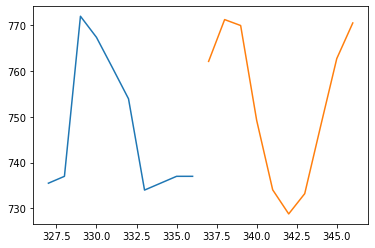

In [29]:
#Selecting last 10 days input from the dataframe df1 for first plot
plt.plot(previous_days1,scaler.inverse_transform(df1[len(df1)-n_steps:]))
#Selecting predicted output from the listof the above function
plt.plot(predicted_future1,scaler.inverse_transform(lst_output))

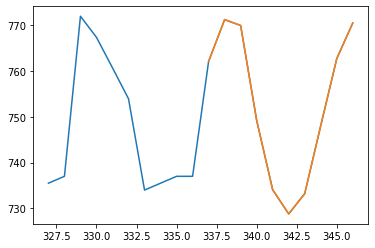

In [30]:
plt.plot(np.append(previous_days1,predicted_future1),scaler.inverse_transform(outputlist[len(df1)-n_steps:]))
plt.plot(predicted_future1,scaler.inverse_transform(lst_output))



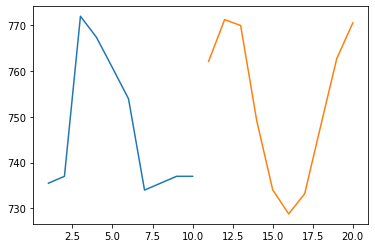

In [31]:
#Selecting last 10 days input from the dataframe df1 for first plot
plt.plot(previous_days,scaler.inverse_transform(df1[len(df1)-n_steps:]))
#Selecting predicted output from the listof the above function
plt.plot(predicted_future,scaler.inverse_transform(lst_output))

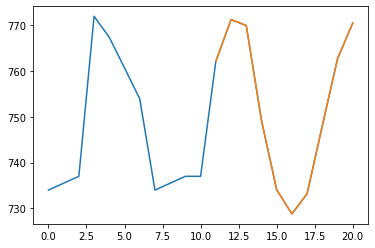

In [32]:
plt.plot(scaler.inverse_transform(outputlist[len(df1)-n_steps-1:]))
plt.plot(predicted_future,scaler.inverse_transform(lst_output))